## Variable-prompt Cash Donations Exploratory Analysis 
**Purpose**   
Previous analysis on the fixed prompt (185 observations from the table below) concluded that the fixed prompt was such a strong influence that it masked other attributes which influence giving - although it did find some significant correlation between donations in the last 24 months and donated amount.  To remove any bias, I believe we need to ask for cash without any prompt.

This version analyses the 2017 June Cash appeal responders to a variable/ personalised prompt (see below, 1,573 observations). It's acknowledged that the personalised prompt creates bias in the data.  But the strategy has been consistent for years and in some sense everyone is given the same treatment, so it might still be valid to look for relationships with mosaic, gender etc.  There might be some danger in analysing previous giving values, as these derive the prompt amount which evidence suggests does strongly influence the donation - so this is probably a little too interlinked to provide valid learning.  None the less, it might be valid to apply a regression model and slowly shift giving behaviour time.  



<img src="June Cash Responses.png">

**Responses ** (as at 30/08/2017)  to KA63 are being analysed.

The active group respond better to the fixed £20 ask, however, the "Income Per Donor Approached" is 4p lower. The lapsed segment perform similarly in terms of response, and the IPDA is lower for the fixed prompt.  

<img src="AvgDonationOverTime.png">

Over time the linear line shows a steady upward trend, however the 12 month average highlights a sizeable drop in average donations between June-2016 to date, after a particularly high average between Christmas 2013 and autumn 2015.

In [1]:
#Loading packages 
from sklearn import datasets, neighbors, metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline 

In [2]:
pd.options.mode.chained_assignment = None  # default='warn', this turns off warnings about slicing data 
np.set_printoptions(suppress=True) # turning off scientific notation.

## Importing data  
Data imported directly from SQL server.

In [3]:
## I ran "pip install pypyodbc" from the command line 
import pypyodbc , pandas as pd 
connection = pypyodbc.connect('Driver={SQL Server};'
                              'Server=INSERT SERVER NAME;'
                              'Database = analystdata;'
                              'Trusted_Connection=yes;')
cursor = connection.cursor()

In [4]:
## just keeping those that responded to a fixed ask for the first stage of modelling 
SQLCommand = ("SELECT * FROM analystdata.dbo.K037_cashTesting_v2 where responded=1 and activitycode in('KA63')") 
cursor.execute(SQLCommand) 

columns = [column[0] for column in cursor.description]
data= cursor.fetchall()

for i in range(0,len(data)):
    data[i]=tuple(data[i])
    
df_orig = pd.DataFrame(data, columns = columns)
connection.close()

In [5]:
##Renaming and dropping features that wouldn't be a predictor (eg personal details, unique ID's) 
#df = df.loc[df['responded'] == 1]  Applied this in SQL above.

features = ['mosaic', #'activitycode', 'prompttype',  #'postcode', 'responded', 'dateprinted','audience',
            'audienceprofile2016', 'donatedamount', 'variableprompt1', #'giftaid','fixedprompt', 'variableprompt2','variableprompt3', 
            'lastdonationemer',  'oneoffavgdonatedlast24m','oneoffavgl12m', 'oneoffdonationsl24m', 
            'everpledgeflag', 'alldonationsavgl24m','firstdonationdate', 'lastdonationdate', 'lastoneoffdate',
            'oneoffltv', 'allltv','lastoneoffamount', 'lastoneoffga', #binary 
            'lifetimedonations', 'monthssincelastoneoff',
            'monthssincefirstdonation', 'monthssincelastdonation']
df = df_orig[features]

# df['donationgiftaid_flag'] = df.giftaid.apply(lambda x: 1 if x > 0 else 0) 

print(df.shape)

## How many nulls are there? What are the datatypes?
for x in df.columns.values:
    print (x,# print variable name 
           ', Type:', df[x].dtypes, #print data type 
           ', Nulls:', df[x].isnull().sum()) # print number of nulls 


(1573, 21)
mosaic , Type: object , Nulls: 21
audienceprofile2016 , Type: object , Nulls: 14
donatedamount , Type: object , Nulls: 0
variableprompt1 , Type: object , Nulls: 0
lastdonationemer , Type: int64 , Nulls: 0
oneoffavgdonatedlast24m , Type: object , Nulls: 0
oneoffavgl12m , Type: object , Nulls: 0
oneoffdonationsl24m , Type: int64 , Nulls: 0
everpledgeflag , Type: int64 , Nulls: 0
alldonationsavgl24m , Type: object , Nulls: 0
firstdonationdate , Type: datetime64[ns] , Nulls: 0
lastdonationdate , Type: datetime64[ns] , Nulls: 0
lastoneoffdate , Type: datetime64[ns] , Nulls: 0
oneoffltv , Type: object , Nulls: 0
allltv , Type: object , Nulls: 0
lastoneoffamount , Type: object , Nulls: 0
lastoneoffga , Type: int64 , Nulls: 0
lifetimedonations , Type: int64 , Nulls: 0
monthssincelastoneoff , Type: int64 , Nulls: 0
monthssincefirstdonation , Type: int64 , Nulls: 0
monthssincelastdonation , Type: int64 , Nulls: 0


In [94]:
##filling nulls 
# df['oneoffavgl12m'].fillna(0, inplace=True)
df['oneoffavgl12m'][df.oneoffavgl12m.isnull() ==True].count()

## Moving "null" audience types into one classification 
df['audienceprofile2016'].fillna("Unclassified") 

# donation as a percentage of the prompt.
df['var_pct'] = df.donatedamount/df.variableprompt1 


##Changing data types

num_features = ['donatedamount','variableprompt1','oneoffavgdonatedlast24m' ,'alldonationsavgl24m',
               'oneoffltv', 'allltv', 'lastoneoffamount','oneoffavgl12m' ]
for x in num_features:
    df[x] = df[x].astype(float)

print(df.dtypes)
df.head(1)

mosaic                              object
audienceprofile2016                 object
donatedamount                      float64
variableprompt1                    float64
lastdonationemer                     int64
oneoffavgdonatedlast24m            float64
oneoffavgl12m                      float64
oneoffdonationsl24m                  int64
everpledgeflag                       int64
alldonationsavgl24m                float64
firstdonationdate           datetime64[ns]
lastdonationdate            datetime64[ns]
lastoneoffdate              datetime64[ns]
oneoffltv                          float64
allltv                             float64
lastoneoffamount                   float64
lastoneoffga                         int64
lifetimedonations                    int64
monthssincelastoneoff                int64
monthssincefirstdonation             int64
monthssincelastdonation              int64
var_pct                             object
dtype: object


,mosaic,audienceprofile2016,donatedamount,variableprompt1,lastdonationemer,oneoffavgdonatedlast24m,oneoffavgl12m,oneoffdonationsl24m,everpledgeflag,alldonationsavgl24m,...,lastoneoffdate,oneoffltv,allltv,lastoneoffamount,lastoneoffga,lifetimedonations,monthssincelastoneoff,monthssincefirstdonation,monthssincelastdonation,var_pct
0,C13,Rapid Responders,20.0,20.0,1,20.0,20.0,2,0,20.0,...,2016-11-14,391.4,391.4,20.0,0,15,8,319,8,1


### Summary Statistics & Plots

       donatedamount      var_pct  variableprompt1
count    1573.000000  1573.000000      1573.000000
mean       21.231087     1.080956        20.430388
std        20.040977     0.572540        14.935093
min         0.250000     0.050000         1.000000
25%        10.000000     1.000000        10.000000
50%        20.000000     1.000000        20.000000
75%        30.000000     1.111111        25.000000
max       360.000000    14.851500       100.000000
donated upper whisker: 60.0
number greater than upper whisker: 51


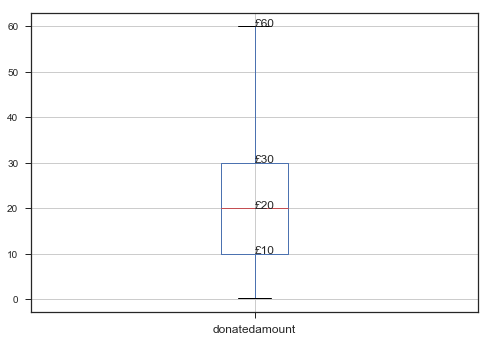

In [72]:
cols=['donatedamount','var_pct', 'variableprompt1']
print(df[cols].describe())
#checking for outliers 
Q1 = df['donatedamount'].quantile(.25)
Q3 = df['donatedamount'].quantile(.75)
print('donated upper whisker:', Q3+((Q3-Q1)*1.5))
print('number greater than upper whisker:',df.mosaic[df.donatedamount>=60].count())


fig, ax = plt.subplots()
box = df.boxplot(column='donatedamount',ax=ax, sym='', figsize=(15,5)) 
ax.margins(y=0.05) # this adds 5% of the range to the y axis
ax.annotate('£10',xy=(1,10))
ax.annotate('£20',xy=(1,20))
ax.annotate('£30',xy=(1,30))
ax.annotate('£60',xy=(1,60))
plt.show()

The donated mean is £21.23 and on average 108% of the prompt (exc gift aid).  
The majority (66%/ 1 std dev) of donations are less than £40 - avg gift £21 +/- std dev £20.  

### Check for normal distributions

<function matplotlib.pyplot.show>

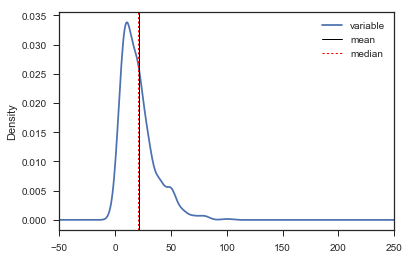

In [73]:
# Donated amount 
label1 = ['variable','mean','median']
ax = df['donatedamount'].plot(kind="density", figsize = (6,4),xlim=(-50,250))# fixed
plt.axvline(df['donatedamount'].mean(),     # Plot black line at fixed mean
           linewidth=1.0,
           color ='black')

plt.axvline(df['donatedamount'].median(),     # Plot red line for variable mean
           linewidth=1.0,
           color ='red', 
           linestyle = ':')

ax.legend(labels=label1)

plt.legend = True
plt.show

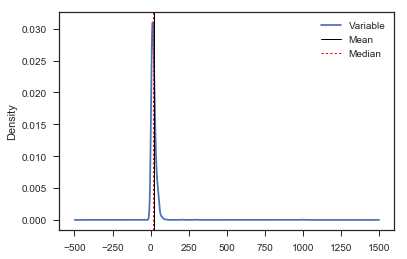

In [84]:
# donated amount last 12 months 
label2  = ['Variable','Mean', 'Median']
ax=df['oneoffavgl12m'].plot(kind="density", figsize = (6,4)) # fixed

plt.axvline(df['oneoffavgl12m'].mean(),     # Plot black line at fixed mean
           linewidth=1.0,
           color ='black')

plt.axvline(df['oneoffavgl12m'].median(),     # Plot red line for variable mean
           linewidth=1.0,
           color ='red', 
           linestyle = ':')
# plt.title('Density plot of One-Off Average Donated Last 24m')
ax.legend(labels=label2)


Observations: 

None of the features are normally distributed, all are positively skewed because each of the features have a lower limit of 0 but an infinite upper limit.  This has the effect of pulling the mean towards the outliers and away from the median.  

**Donated amount** has two spikes around the £20 and £50 price points.

### Correlation

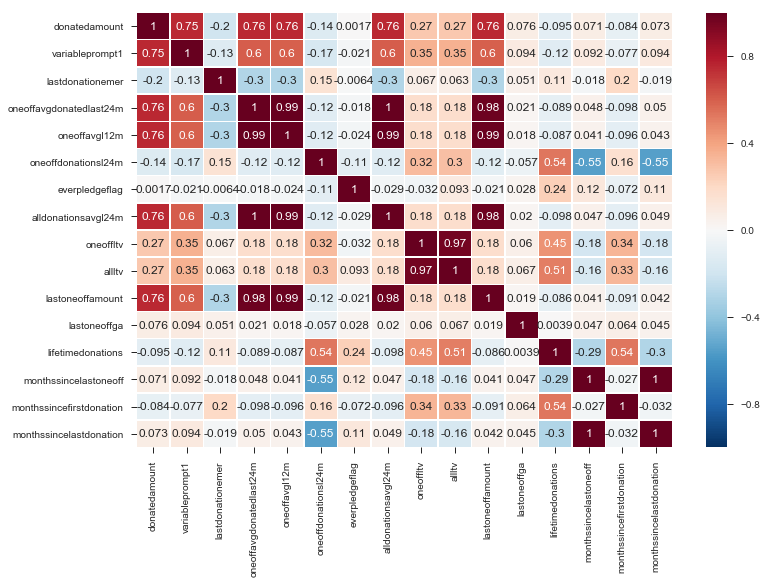

In [95]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)

### Correlation observations: 
The **variable prompt** has a strong correlation with the amount donated (0.75), in the previous lapsed analysis the correlation was much lower 0.33 - perhaps suggesting that the prompt strategy is better suited to active supporters.  

*Update 19/09/17 Added the oneoffavgl12m with has 0.78 correlation with donatedamount.* 

All donations are more correlated than just one-off donations with donated amount:
**alldonationsavgl24m**         0.76 (0.42)  
**oneoffavgdonatedlast24**      0.58 (0.15)  

Last one-off amount is correlated:
**lastoneoffamount**            0.76 (0.46)  

The LTV features aren't correlated with the donated amount:
**allltv**                      0.27 (0.27)  
**oneoffltv**                   0.27 (0.26)

The **"Months since"** variables continue to show a very weak correlation (less than 0.1) with donatedamount. 

nb anything that is a binary flag, isn't techinically a continous variable and therefore correlation isn't appropriate, see graphs below.  

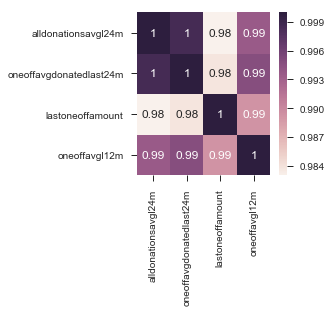

In [96]:
## checking for colinearity between the features.
predictors  = ['alldonationsavgl24m','oneoffavgdonatedlast24m', 'lastoneoffamount', 'oneoffavgl12m']
f,ax = plt.subplots(figsize=(3,3))
sns.heatmap(df[predictors].corr(), annot = True,ax=ax)

**Remove lastoneoffamount** which is highly correlated with Alldonationsavgl24m.

### Transforming data

oneoff avg l12 mths correlation: 0.756868248578
oneoffL12_log correlation: 0.908527951493


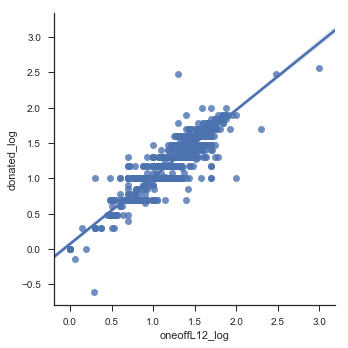

In [97]:
sns.set(style='ticks') #remove gridlines

log_columns = ['alldonationsavgl24m', 'donatedamount','lastoneoffamount','oneoffavgl12m']
new_columns = ['alldonations_log','donated_log','lastoneoff_log', 'oneoffL12_log']
df[new_columns] = df[log_columns].apply(np.log10)

sns.lmplot( 'oneoffL12_log','donated_log', df) 
print('oneoff avg l12 mths correlation:',df['donatedamount'].corr(df['oneoffavgl12m']))
print('oneoffL12_log correlation:',df['donated_log'].corr(df['oneoffL12_log']))

# print('alldonations_log correlation:',df['donated_log'].corr(df['alldonations_log']))
# print('lastoneoff_log correlation:',df['donated_log'].corr(df['lastoneoff_log']))

The correlation with donated amount improves when predictors are logged, from 0.75 to 0.90.      
Unlike previous analysis there seems to be more of a linear relationship suggesting that a regression model might be a good fit.

### Splitting the data 

In [98]:
# Creating a training set 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2)

**Running simple linear regression to understand how much of donated amount all donations last 24 months can explain...**

In [99]:
from sklearn import linear_model, metrics, cross_validation, feature_selection
    
X = train[['alldonations_log']]
y = train['donated_log']
pvals = feature_selection.f_regression(X, y)[1]# get the pvalue of X given y.

lm = linear_model.LinearRegression().fit(X,y)
print('coef',lm.coef_)
print('intercept',lm.intercept_)
print('r2',lm.score(X,y))
print('pval',pvals)


coef [ 0.9525929]
intercept 0.071918860425
r2 0.80898201638
pval [ 0.]


All donations last 24 months can explain 80% of donations. This isn't so surprising since the prompt amount is derived from previous giving and the prompt is heavily correlated with the donated amount.  

## Analysing categorical variables 

volume with GA flag 1040
lastoneoffga
0    19.111163
1    22.317548
Name: donatedamount, dtype: float64

volume with pledge flag 98
everpledgeflag
0    21.222231
1    21.364388
Name: donatedamount, dtype: float64


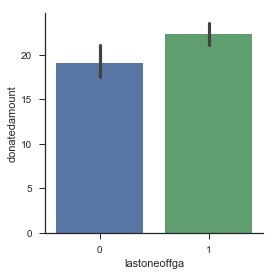

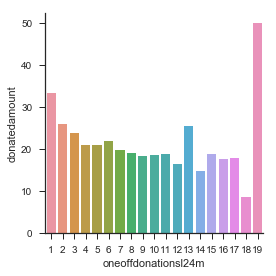

In [84]:
# donation amount by whether GA was given in the last donation 
sns.factorplot(kind='bar', y='donatedamount', x='lastoneoffga', data=df) 

# count of donations in the last 24 months
g=sns.factorplot(kind='bar', y='donatedamount', x='oneoffdonationsl24m', data=df,ci=False) 

# Do the binary GA and pledge flags affect donation?
print ('volume with GA flag',df['lastoneoffga'].sum())
print(df.donatedamount.groupby(df.lastoneoffga).mean())
print('')
print ('volume with pledge flag',df['everpledgeflag'].sum())
print(df.donatedamount.groupby(df.everpledgeflag).mean())

# categorical = ['lastoneoffga']

Whether the supporter has **previously pledged** doesn't alter the donation amount.  However, if the supporter gave **gift aid** in their last donation then this has a positive effect on the donated amount this time (exc Gift Aid) -  however the r2 is very low, which tells us that it doesnt explain donatedamount.

**Volume of donations** in the last 24 months shows a negative relationship with the donated amount. There's some arguement to suggest that fewer donations enables supporters to give a little more each time.  The table below shows that only 1 supporter has given 19 times.  
NB the number of donations is generally as a result of the number of asks we make and the supporter isn't necessarily in control of how this - so I don't think it is a valid feature to include in a model.  
<font color='red'/> Creating an "avg donation per approach" might be sensible? </font>

In [99]:
# Running simple linear regression on gift aid flag to see if it's statistically significant/ explains 
X = df[['lastoneoffga']]
y = df['donatedamount']

lm = linear_model.LinearRegression().fit(X,y)
pvals = feature_selection.f_regression(X,y)[1]
print('coef',lm.coef_)
print('intercept',lm.intercept_)
print('r2',lm.score(X,y))
print('pval',pvals)

coef [ 3.20638485]
intercept 19.111163227
r2 0.00573816190065
pval [ 0.00264462]


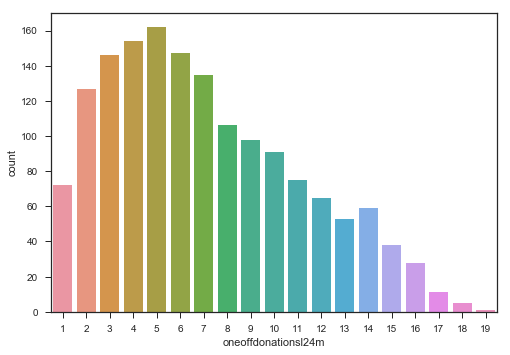

In [249]:
pd.crosstab(df.oneoffdonationsl24m,'')
sns.countplot( x='oneoffdonationsl24m', data=df) 

** Last donation was to an emergency ** 

mean donated amount lastdonationemer
0    51.675926
1    20.699386
Name: donatedamount, dtype: float64


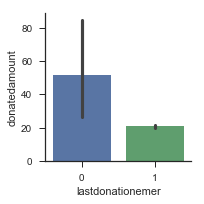

In [251]:
# looking at how lastdonationemer (categorical variables) affects the distribution of donated amount
sns.factorplot(
    x='lastdonationemer',
    y='donatedamount',
    data=df, 
    kind='bar', 
    size =3)

print( 'mean donated amount',df['donatedamount'].groupby(df.lastdonationemer).mean())

pd.crosstab(df.lastdonationemer,"volume")

categorical.append('lastdonationemer')

Only 27 supporters hadn't given to an emergency on their last donation.  These 27 show a significantly higher average gift of £51 vs £20.

In [100]:
# Running simple linear regression on last donation emer to see if it's statistically significant
X = df[['lastdonationemer']]
y = df['donatedamount']

lm = linear_model.LinearRegression().fit(X,y)
pvals = feature_selection.f_regression(X,y)[1]
print('coef',lm.coef_)
print('intercept',lm.intercept_)
print('r2',lm.score(X,y))
print('pval',pvals)

coef [-30.97654041]
intercept 51.6759259259
r2 0.0403292394647
pval [ 0.]


P-value <0.05 confirms that it is significant.

### Creating dummies
### Mosaic 

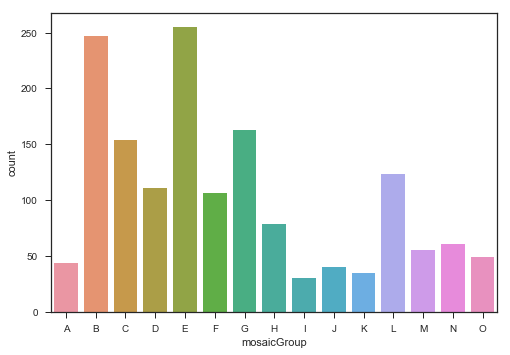

In [101]:
df['mosaicGroup'] = df['mosaic'].str[:1]
# pd.crosstab('count',df.mosaicGroup)

df.sort_values('mosaicGroup',inplace=True) # need to sort the df first
sns.countplot(df.mosaicGroup)

In [102]:
mosaic = pd.get_dummies(df.mosaicGroup)
mosaic = mosaic.ix[:,0:14] # dropping dummy O 

### Function for linear regression model

In [139]:
from sklearn import linear_model, feature_selection
lm =linear_model.LinearRegression()

def get_linear_model_metrics(X, y, algo):
    pvals = feature_selection.f_regression(X, y)[1]# get the pvalue of X given y. 
    algo.fit(X,y) # .fit() runs the linear regression function on X and y
    residuals = (y-algo.predict(X)).values

    print('P Values:',pvals) 
    print('Coefficients:', algo.coef_)
    print('y-intercept:', algo.intercept_)
    print('R-Squared:', algo.score(X,y))
    print('MSE', metrics.mean_squared_error(y,lm.predict(X)))
#     plt.figure()
#     plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))
    return algo # keep the model

In [109]:
print(mosaic.columns)
y= df.donatedamount
get_linear_model_metrics(mosaic, y, lm)  #mosaic[[0,7]] # A and H
print 


Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'], dtype='object')
P Values: [ 0.01130253  0.18553119  0.11688429  0.51486172  0.54263615  0.38821692
  0.94955628  0.02029019  0.42410402  0.25575904  0.23127421  0.87190779
  0.11410482  0.88655513]
Coefficients: [ 5.64415584 -0.34715442  0.50779221 -0.70262548 -2.59719888 -3.52008086
 -1.80341805 -6.99566004 -4.7952381  -5.45357143 -5.90828571 -2.17735192
 -6.09220779 -1.53840749]
y-intercept: 23.1285714286
R-Squared: 0.014511719126
395.560634905


<function print>

Mosaic alone describe very little of the donatedamount, as shown r2 of 0.01.

Only the P-values for A and H are lower than 0.05. The coefficients tells us that if the supporter belongs to A then the donationamount increases by £5.64, whilst if H the donation decreases by £6.99.

In [118]:
## Appending Mosaic group A and H
df = pd.concat([df, mosaic[[0,7]]], axis=1)

### Target Audience

In [110]:
audience = pd.get_dummies(df.audienceprofile2016) 
audience.drop('Unclassified',inplace=True, axis=1)
audience.head(1)

,Mindful Mums,Not in target,Rapid Responders,Upwardly Urban,Wealthy Wellwishers
199,0,0,0,1,0


In [228]:
pd.crosstab(df.audienceprofile2016,'')

audienceprofile2016
Mindful Mums            59
Not in target          656
Rapid Responders       336
Unclassified             7
Upwardly Urban         228
Wealthy Wellwishers    273
Name: __dummy__, dtype: int64

In [122]:
print(audience.columns)
get_linear_model_metrics(audience, y, lm) #[[0,1,2,3,4]]

Index(['Mindful Mums', 'Not in target', 'Rapid Responders', 'Upwardly Urban',
       'Wealthy Wellwishers'],
      dtype='object')
P Values: [ 0.43231379  0.02968678  0.91480976  0.08285461  0.17231036]
Coefficients: [-7.20823245 -6.49608667 -5.30125    -3.06892231 -3.69227106]
y-intercept: 26.4285714286
R-Squared: 0.00564993743654
399.117624936


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Only the "not in target" group have a significant P-value. Again **very little of the donated amount can be explained by** Audience.

In [123]:
# Rerunning to get coefficient without the other features influence:
get_linear_model_metrics(audience[[1]], y, lm)
print 

P Values: [ 0.02968678]
Coefficients: [-2.22759158]
y-intercept: 22.1600763359
R-Squared: 0.00300555904251
400.179039888


<function print>

"not in target" decreases the donation by £2.22 from an intercept of £22.16.  This suggests that if you're "not in target" then the donation value is £20 (c.average), whilst if you are in any of the target audiences the value increases to £24.

In [124]:
## appending significant audiences to the main df
df = pd.concat([df, audience[[1]]], axis=1)

#resampling now i've added the dummies
train, test = train_test_split(df, test_size = 0.2)

## Model builds

In [200]:
train.columns
cols_to_keep = ['alldonations_log','Not in target','A','H','lastoneoffga'] #'lastdonationemer', not significant
Xtr= train[cols_to_keep]
ytr= train['donated_log']
get_linear_model_metrics(Xtr,ytr,lm)

P Values: [ 0.          0.01295228  0.04828956  0.00398248  0.00000699]
Coefficients: [ 0.94016004 -0.00074969 -0.01018203 -0.01280075  0.01005627]
y-intercept: 0.0799479797313
R-Squared: 0.81225532896
MSE 0.0208466559293


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Aside from alldonations_log the coefficients are very small, suggesting that the **categorical variables** have very little influence - this also evidenced in the very small r2 of earlier simple regression models.  

The r2 including the categorical variables doesn't improve from 81% seen when only alldonations is used.

**Update**  
After preparing a scoring script for future selections, I realised that having "all" donations might be dangerous if it's not applied to a cash audience (as it has been here). Therefore I logged the **last cash donation** which has a 0.88 correlation with the logged donation amount and an R2 of 0.77 (compared to 0.81 when alldonationsavgL24m was used) - but I wasn't happy to base our prediction on only one value.  

I went back to the SQL and build a **oneoffAvgL12m** variable and similarly logged it. Before logging the correlation was 0.78 and after it is **0.907**

In [100]:
X = train[['oneoffL12_log']]
y = train['donated_log']
pvals = feature_selection.f_regression(X, y)[1]# get the pvalue of X given y.

lm = linear_model.LinearRegression().fit(X,y)
print('coef',lm.coef_)
print('intercept',lm.intercept_)
print('r2',lm.score(X,y))
print('pval',pvals)


coef [ 0.95597751]
intercept 0.0625615824487
r2 0.822676711912
pval [ 0.]


### Cross Validation

In [101]:
Xtr= train[['oneoffL12_log']]
ytr= train['donated_log']
# len(ytr)

In [102]:
# printing out MSE based on diffrent CV k-folds
for i in range (2,20,1):# list of numbers from 1 to 19.
    kf = cross_validation.KFold(len(train), n_folds=i)
    scores = []
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(Xtr.iloc[train_index], ytr.iloc[train_index])
    # Scoring the test index of the training set.
    scores.append(metrics.mean_squared_error(ytr.iloc[test_index], lm.predict(Xtr.iloc[test_index])))
 
    print (np.mean(scores))

0.0168998311202
0.014372377232
0.015240765161
0.0173232286589
0.0168363782703
0.0164180031421
0.0171112914477
0.0162126205905
0.0165721624968
0.0177885941148
0.0176602695668
0.0188563918214
0.0185579056157
0.0183848106687
0.018528765942
0.0194833798832
0.0193707830687
0.0199576094407
0.0199764581818


The training set is looping around 1 cross validation fold to 19. Eg. where the number of folds is 5, there are 5 iterations of the model build, built from 4/5ths of the data. The 1/5th not being used to build the model is instead used to validate the model using the Mean Squared Error - because there are 5 model builds, there are 5 error readings we take the Mean Standard Error. This is a measure of variance between the actual and the predicted value (error).  

The MSE is calculated on the portion left out of the model build, but we also have a seperate test set, which will be used later to further validate the model.  

The smallest error value is achieved with c.**5 cross validation folds** - I haven't chosen 1-3 folds because I don't think this would best equip/ generalise the model enough so that it continues to predict well on unseen data.

### Checking other estimators

In [103]:
CV=cross_validation.KFold(n=len(Xtr),n_folds=5)

# loading other sklearn regression estimators
estimators = [
    linear_model.LassoCV(cv=CV),
    linear_model.RidgeCV(cv=CV), # Ridge regression addresses some of the problems of Ordinary Least Squares by 
                                 # imposing a penalty on the size of coefficients.
    linear_model.ElasticNetCV(cv=CV),]

for est in estimators:
    est.fit(Xtr, ytr)
    print (est)
    print('MSE:', metrics.mean_squared_error(ytr, est.predict(Xtr))) # this is training MSE.
    print('R-Squared:', est.score(Xtr,ytr))
    

LassoCV(alphas=None, copy_X=True,
    cv=sklearn.cross_validation.KFold(n=1258, n_folds=5, shuffle=False, random_state=None),
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)
MSE: 0.019873739791
R-Squared: 0.822675889236
RidgeCV(alphas=(0.1, 1.0, 10.0),
    cv=sklearn.cross_validation.KFold(n=1258, n_folds=5, shuffle=False, random_state=None),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)
MSE: 0.0198737047373
R-Squared: 0.822676202004
ElasticNetCV(alphas=None, copy_X=True,
       cv=sklearn.cross_validation.KFold(n=1258, n_folds=5, shuffle=False, random_state=None),
       eps=0.001, fit_intercept=True, l1_ratio=0.5, max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

The new estimators do not improve the r2/ reduce the MSE, so will continue to use LinearRegression.

### Final model  
**LinearRegression ** estimator & 10 CV folds

In [104]:
kf = cross_validation.KFold(len(train), n_folds=5) # shuffle = shuffle data before folding.
scores = []

Xtr= train[['oneoffL12_log']] 
ytr= train['donated_log']

for train_index, test_index in kf:
    ## Model built using the training set
    lm = linear_model.LinearRegression().fit(Xtr.iloc[train_index], ytr.iloc[train_index]) 
    ##Predictions made on the test set
    scores.append(metrics.mean_squared_error(ytr.iloc[test_index], lm.predict(Xtr.iloc[test_index]))) 

print ('MSE with folds:',np.mean(scores)) # MSE
print('R-Squared:', est.score(Xtr,ytr))

print('Coefficients:', est.coef_)
print('y-intercept:', est.intercept_)


# lm = linear_model.LinearRegression().fit(Xtr, ytr)
# print ('without folds:',metrics.mean_squared_error(ytr, lm.predict(Xtr)))
# print('R-Squared:', est.score(Xtr,ytr))

MSE with folds: 0.019984362323
R-Squared: 0.822673570486
Coefficients: [ 0.95410943]
y-intercept: 0.0647884719531


### Applying the model to the test set

C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\BeckyC\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


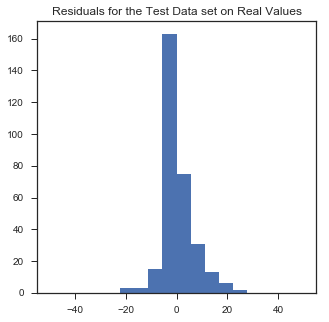

Residual median- Real values: -0.265829150352
MSE (Logged Values): 0.0192480348403
Root MSE (Real Values) 1.37637662101


In [108]:
X = test[['oneoffL12_log']]
len(X)
test['ols_pred_log']= lm.predict(X)
test['ols_pred'] = 10**test.ols_pred_log # reversing the log10

# residuals
residuals = (test.donatedamount-test.ols_pred).values # .values creates an array rather than a df 
plt.figure(figsize=(5,5))
plt.hist(residuals, np.ceil(np.sqrt(len(residuals))),range=(-50,50))
plt.title("Residuals for the Test Data set on Real Values")
plt.show()

print('Residual median- Real values:',np.median(residuals))
print('MSE (Logged Values):', metrics.mean_squared_error(test.donated_log,test.ols_pred_log)) 
# print('MSE (Real Values):', metrics.mean_squared_error(test.donatedamount,test.ols_pred)) 
print('Root MSE (Real Values)',10**np.sqrt(metrics.mean_squared_error(test.donated_log,test.ols_pred_log)))


You can see from the graph above that the difference between the prediction and actuals, aka residuals, are centred around zero.  Expressed by the median of the residuals which is -0.26,a pretty good result!

The MSE from the Cross Validation is 0.016, this marginally increases to 0.019- which proves that the model can predict **unseen test data** almost as well as it can predict from the "seen" observations.  

The root of the MSE converts the MSE into pounds, RMSE can be interpreted as the standard deviation of the residuals- i.e. 65% of observations are within *+/- £1.37* of the true value.  

I also ran the model against a sample of supporters who **responded to cash appeals 2015 and 2016** - unseen data during the model build. The analysis was carried out in SQL - see the script "Validating on previous campaigns".  The RMSE for this sample is *£1.03*.

*(results using a log of lastoneoff, each of the metrics below performed marginally worse:  
Median: -0.56   
MSE Test data 0.021  
RMSE: £9.90) *   

*(results using a log of alldonationsl24m, each of the metrics below performed marginally worse:  
Median: -0.59   
MSE Test data 0.026  
RMSE: £10) *   


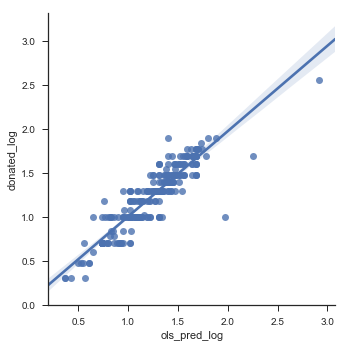

In [109]:
##Donation Vs Prediction scatter
sns.lmplot('ols_pred_log','donated_log', test,size=5)

In [114]:
test[['oneoffL12_log', 'donated_log','ols_pred_log','oneoffavgl12m','donatedamount','ols_pred']].head(10)

,oneoffL12_log,donated_log,ols_pred_log,oneoffavgl12m,donatedamount,ols_pred
1512,1.000000,1.00000,1.021859,10.0000,10.0,10.516208
1077,1.000000,1.00000,1.021859,10.0000,10.0,10.516208
249,1.544068,1.60206,1.536784,35.0000,40.0,34.417870
954,0.726996,1.00000,0.763479,5.3333,10.0,5.800678
860,1.000000,1.00000,1.021859,10.0000,10.0,10.516208
978,1.000000,1.00000,1.021859,10.0000,10.0,10.516208
20,1.301030,1.30103,1.306764,20.0000,20.0,20.265829
796,1.096910,1.00000,1.113578,12.5000,10.0,12.989073
604,1.477121,1.30103,1.473423,30.0000,20.0,29.745634
1204,1.301030,1.60206,1.306764,20.0000,40.0,20.265829


## Conclusion 
### y = intercept * x + coef
### Donated Amount =0.0647884719531+ oneoffL12_log *  0.95410943 
The intercept tells us that donations (logged) start at 0.06, and for each unit increase in the last donation amount there is a 0.95 (coeficient) rise in the donated amount.  

*(Previous versions  
**using last oneoff donation** 
Donated Amount = 0.132373738638+ lastoneoff_log x 0.89887573  
**using all donations **
Donated Amount  = 0.0895737922315 + AllDonations_log x 0.94055303)

The analysis does not find a significant relationships with mosaic, gender etc as was intially hoped.  The best predictors of donated amount continue to be continuous variables measuring historic giving.
 
 A linear/ correlated relationship exists between the prompt value and historic one-off giving, this has been shown on the last one-off amount, a 12 month history and a 24 month history.  There is strong colinearity between the last one-off gift and the average of all donations in the last 24 months. The average of all donations was initially preferred because it has a marginally higher correlation with the donation amount.  
  
However, although the greatest correlation was observed using an average of "all" donations, this data is a sample of cash supporters and "all" is mainly cash giving, and there's a danger that the algorithm will be applied to a different population where that relationship is different.  So I have since ammended the model to look at a history of only one-off donations - which actually improved the r2 and MSE.

Logging the predictor and outcome improves the correlation with donated amount and suggests that a linear model is suitable for this problem.
  
As seen in previous analysis, the categorical features can't help explain the donated amount; Mosaic, Audience, Last donation was an emergency, last donation included gift aid, has previously had a pledge.  

<img src="NewVsOldPromptDist.png">

The chart above shows the distribution of new and old prompts on a sample of supporters who sit in Low Value cash DM Segments O,P &Q and who've given in the last 4 years.  

The old strategy should round up to the nearest £5, in practice I don’t think it does, which explains why more sit in the £5 bin for the current strategy (i.e. they are £7 prompts rounded down to £5 instead of up) compared to the new formula.  

The current strategy caps the prompt at £100, but I think there’s a good argument to extend this to £200 – the £100+ bin  represents this new group (which is 2.5% of this sample).

As a result the average prompt for the old strategy is £26.83 and £34.19 for the new strategy- so I think it sets the scene for a really interesting test!  

I also looked at the variance between the donated amount and the new prompted value. Prompts up to £70 stretch donors (on average by £2) compared to their 12 month average.  Whilst the old strategy prompts on average £3.77 **less** than the 12 month donated average. Prompts greater than £70 are less than the 12 month donation average for both the old and new strategy, on average by -£2.79 and -£4.37, respectively. 
